# Understanding Current Exoplanet Populations Using a Little Monte Carlo

> Hello there! I created this code with two goals in mind: __to use a computational method in physics to better understand it, and to use real data to understand some of what we know today about the general question of habitability__. Since this is being created with a deadline for a class, and for people that are new to the field of exoplanets, and particular the question of habitability, I will be restricting the question we ask today to this - using the current database of exoplanets we have detected and confirmed within a small region of the Milky Way Galaxy, __how can we understand the potential for Earth-like habitable planets__? The probability? 
<br>
> To do so, we will use Earth as a comparison point throughout the notebook, and explore the population using mass and radius first, then stellar parameters. Looking at our Solar System, we know that the Earth is unique in its composition, temperature, size, and location. We will start with a dataset provided by using the __[NASA Exoplanet Archive](https://exoplanetarchive.ipac.caltech.edu/index.html)__, ensure that the dataset we actually use has both mass and radius for each planet entry, and then use a Monte Carlo sampling method to randomly select planets and their systems. We will then take those planets, and narrow them down to what the __[Planetary Habitability Laboratory @ UPR Arecibo](https://phl.upr.edu/projects/habitable-exoplanets-catalog)__ considers apt mass and radius ranges, and reselect (randomly, again) some planets from within that range to see which, if any, fall within a Goldilocks zone from their host star/s - the area that surrounds that "just right" spot that Earth lives in. Maybe then we might find some optimism or skepticism about the question of whether we have the most unique planet out there!


In [1]:
#pull distribution of mass, radius from monte carlo, then plot the distancexluminosity to see the distribution, then redo monte carlo on sliver of radius, mass (habitable planets) - and check if they're the same distribution, can overlap 2d histograms of normal mass radius dists and habitable zone dists

#Here is the code for turning our csv data file into a dictionary to use for analyzing the data
import pandas as pd
import numpy as np
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from PIL import Image
import moviepy
from moviepy.editor import ImageSequenceClip
import natsort as nt
from IPython.display import Video
import re
import os

#Initializing the style I want to use, you can look up 'plt.style.use' to find out what you'd like to use!
plt.style.use('Solarize_Light2')

#Loading an image to use later
pl_earth = mpimg.imread('earf.png')
height, width, _ = pl_earth.shape
aspect_ratio = width/height
#A function just to make our lives easier with spacing issues when it comes to naming things
def rename(name):
    name = name.replace(' ', '_')
    return name

#Creating a dataframe
exo_data = pd.read_csv(r'/Users/shirin/Desktop/comp_meth/final_project/exo_data.csv',encoding='unicode_escape',comment='#')
exo_data.head() #showing the top 5 lines of the dataframe

,pl_name,hostname,pl_orbper,pl_orbsmax,pl_rade,pl_bmasse,pl_orbeccen,pl_insol,pl_eqt,st_spectype,st_teff,st_rad,st_metratio,st_lum,rastr,ra,decstr,dec
0,11 Com b,11 Com,323.21000,1.178,12.2,4914.89849,0.238,NaN,NaN,G8 III,4874.0,13.76,[Fe/H],1.978,12h20m42.91s,185.178779,+17d47m35.71s,17.793252
1,11 UMi b,11 UMi,516.21997,1.530,12.3,4684.81420,0.080,NaN,NaN,K4 III,4213.0,29.79,[Fe/H],2.430,15h17m05.90s,229.274595,+71d49m26.19s,71.823943
2,14 And b,14 And,186.76000,0.775,13.1,1131.15130,0.000,NaN,NaN,K0 III,4888.0,11.55,[Fe/H],1.840,23h31m17.80s,352.824150,+39d14m09.01s,39.235837
3,14 Her b,14 Her,1765.03890,2.774,12.6,2559.47216,0.373,NaN,NaN,K0 V,5338.0,0.93,[Fe/H],-0.153,16h10m24.50s,242.602101,+43d48m58.90s,43.816362
4,16 Cyg B b,16 Cyg B,798.50000,1.660,13.5,565.73740,0.680,NaN,NaN,G3 V,5750.0,1.13,[Fe/H],0.097,19h41m51.75s,295.465642,+50d31m00.57s,50.516824


The dataframe above displays the header, or top 5 rows of data that we put into the code. Currently, the dataframe includes the planet name, host star name, the planet's orbital period, the planet's semi-major axis (furthest distance from the host star/s), radius in Earth radii, mass in Earth masses, orbital eccentricity, insolation flux, equilibrium temperature, the star's spectral type, effective temperature, radius in solar radii, metallicity ratio, luminosity, and the system's right ascension and declination in both sexagesimal and decimal systems. For the ease of understanding what we're looking at, let's clean up the names of the data!

In [2]:
#Renaming the columns... It's a long line.
exo_data = exo_data.rename(columns={'pl_name': 'Planet Name', 'hostname': 'Star Name', 'pl_orbper': 'Orbital Period [days]', 'pl_orbsmax': 'Semimajor Axis [au]', 'pl_rade': 'Planet Radius [Earth radii]', 'pl_bmasse': 'Planet Mass [Earth masses]', 'pl_orbeccen': 'Eccentricity', 'pl_insol': 'Insolation Flux [Earth flux]', 'pl_eqt': 'Equilibrium Temperature [K]', 'st_spectype': 'Spectral Type', 'st_teff': 'Stellar Effective Temperature [K]', 'st_rad': 'Stellar Radius [solar radii]', 'st_metratio': 'Stellar Metallicity Ratio', 'st_lum': 'Stellar Luminosity [log10(solar)]', 'rastr': 'RA [sexagesimal]', 'ra': 'RA [decimal]', 'decstr': 'Dec [sexagesimal]', 'dec': 'Dec [decimal]'})
print("DataFrame after renaming: ", exo_data)

DataFrame after renaming:       Planet Name Star Name  Orbital Period [days]  Semimajor Axis [au]  \
0       11 Com b    11 Com             323.210000             1.178000   
1       11 UMi b    11 UMi             516.219970             1.530000   
2       14 And b    14 And             186.760000             0.775000   
3       14 Her b    14 Her            1765.038900             2.774000   
4     16 Cyg B b  16 Cyg B             798.500000             1.660000   
...          ...       ...                    ...                  ...   
5552   ups And b   ups And               4.617033             0.059222   
5553   ups And c   ups And             241.258000             0.827774   
5554   ups And d   ups And            1276.460000             2.513290   
5555   ups Leo b   ups Leo             385.200000             1.180000   
5556    xi Aql b    xi Aql             136.970000             0.625000   

      Planet Radius [Earth radii]  Planet Mass [Earth masses]  Eccentricity  \
0    

The way we renamed this might seem a bit painful (as some of the keys are now quite wordy), but at least personally it feels worth it when the plots show the data, and the axes show us exactly what the data is, including the units! A few of the keys we should keep in mind are mass, radius, semimajor axis (in astronomical units (au) the distance from the center of an ellipse to the farther point out on it, and we can consider it some measure of a distance from the star although we must keep in mind that not all orbits in the Universe are circular), stellar luminosity (the total amount of energy radiated by the star relative to the Sun), insolation flux (the amount of stellar radiation received by a planet), and stellar effective temperature (the energy/heat the star radiates, in Kelvin). As we go forward, keep in mind that the __Earth is 1 Earth mass, 1 Earth radius, and 1 AU away from the Sun, with 1 Earth flux for its insolation flux__. __The Sun's temperature is 5780 K, and its luminosity is 1 solar luminosity__.

Now, just to make sure our data is being read and can be plotted, let's create a scatterplot testing the locations of planets and their systems in an RA and dec plot!

<Axes: xlabel='RA [decimal]', ylabel='Dec [decimal]'>

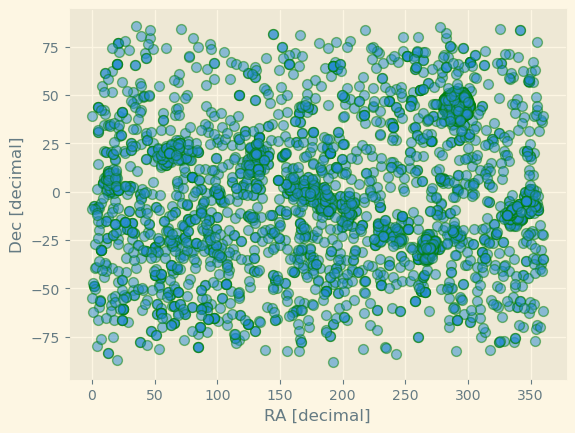

In [3]:
exo_data.plot.scatter(x='RA [decimal]', y='Dec [decimal]', s=50, edgecolor='green', grid=True, alpha=0.5)

Awesome! This is also a really cool way of seeing some of the data before we try and understand it. We can see that our data skews more towards considering our current observations of planets as singular planets about their host stars, even though there might be more! It seems far harder to find multi-planet systems.

As you've seen from the dataframe above, we have multiple parameters of data to work with when it comes to exoplanets. For now, let's try to explore one kind of question in exoplanet science with the dataframe we have, the question of habitability. For that, we can try and use the masses and radii of the planets we want to work with! You'll note that both those parameters are listed in Earth and Jupiter terms, but I think that comparing exoplanets to Earth feels the most natural to me, so I'll stick with that!

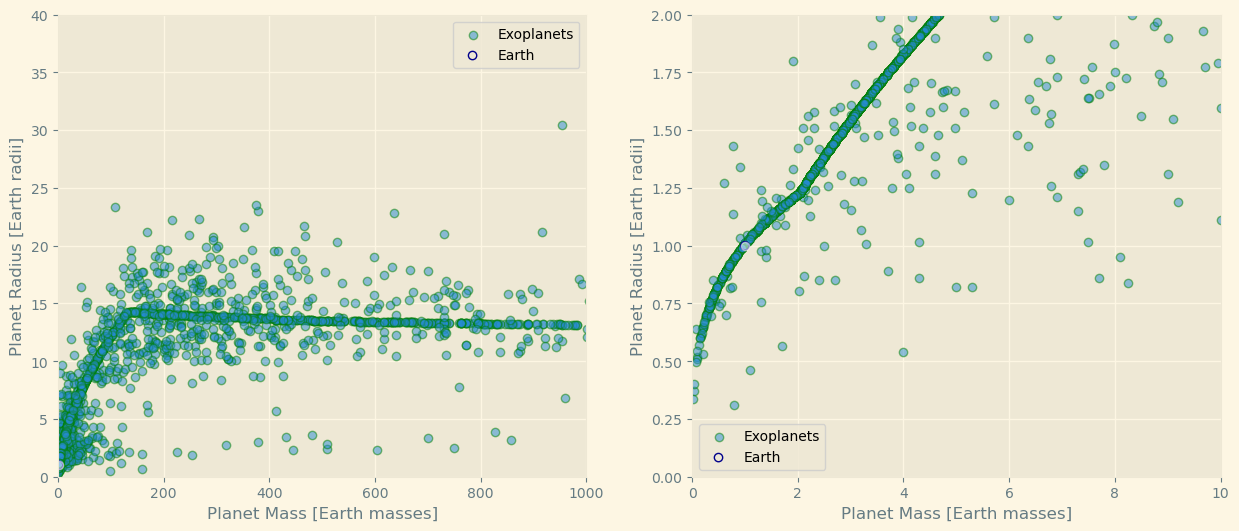

In [4]:
fig = plt.figure(figsize=(15, 6))

ax1 = fig.add_subplot(121)
ax1.scatter(exo_data['Planet Mass [Earth masses]'], exo_data['Planet Radius [Earth radii]'], alpha=0.5, edgecolor='green', label='Exoplanets')
ax1.scatter(1,1,marker='o', color='darkblue', label='Earth', facecolor='none')
ax1.scatter(1,1,marker='o', color='white', alpha=0.5)
ax1.set_xlabel('Planet Mass [Earth masses]')
ax1.set_ylabel('Planet Radius [Earth radii]')
ax1.set_xlim(0,1000)
ax1.set_ylim(0,40)
plt.legend()

ax2 = fig.add_subplot(122)
ax2.scatter(exo_data['Planet Mass [Earth masses]'], exo_data['Planet Radius [Earth radii]'], alpha=0.5, edgecolor='green', label='Exoplanets')
ax2.scatter(1,1,marker='o', color='darkblue', label='Earth', facecolor='none')
ax2.scatter(1,1,marker='o', color='white', alpha=0.5)
ax2.set_xlabel('Planet Mass [Earth masses]')
ax2.set_ylabel('Planet Radius [Earth radii]')
ax2.set_xlim(0,10)
ax2.set_ylim(0,2)

plt.legend()

#Check for NaNs in the column
#nan_checker = exo_data[exo_data['Planet Mass [Earth Masses]'].isnull()]
#print("Rows with NaN values:")
#print(nan_checker)

Woah! This plot looks a bit strange to me, personally. Reading it, I can see a variety of radii for the planets, from smaller than our planet to larger (20+ Earth radii), but a lot of the masses of the planets seem to hang around 0 Earth masses... Could that be right? Maybe we should try and look at some of the literature to check it. https://link.springer.com/article/10.1134/S0038094621030084

In [5]:
exo_data = exo_data.dropna()
print(len(exo_data))
#nan_checker = exo_data['Planet Mass [Earth Masses]'].isnull()
#print("Rows with NaN values:")
#print(nan_checker)

731


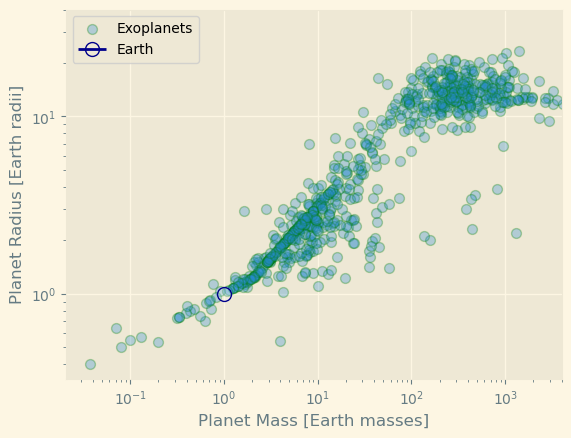

In [6]:
ax = exo_data.plot(x='Planet Mass [Earth masses]', y='Planet Radius [Earth radii]', alpha=0.3, xlim=(0,4000), ylim=(0,40), kind='scatter', logx=True, logy=True, s=50, edgecolor='green', label='Exoplanets')
ax.plot(1, 1, marker='o', color='white', alpha=0.2, markersize=10)
ax.plot(1, 1, marker='o', color='darkblue', markersize=10, markerfacecolor='none', label='Earth')
ax.legend()

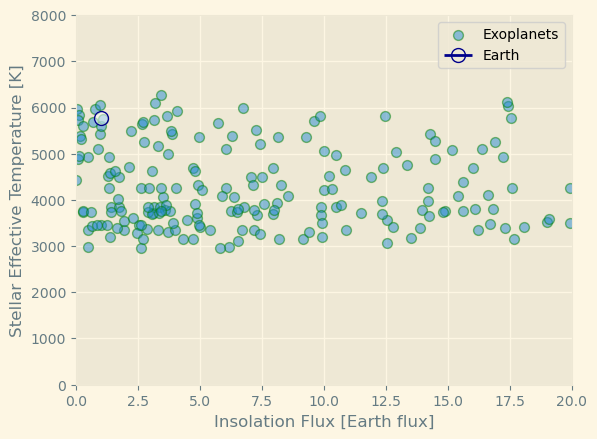

In [7]:
ax = exo_data.plot.scatter(x='Insolation Flux [Earth flux]', y='Stellar Effective Temperature [K]', alpha=0.5, s=50, xlim=(0,20), ylim=(-1,8000), edgecolor='green', label='Exoplanets')
ax.plot(1, 5780, marker='o', color='white', alpha=0.5, markersize=10)
ax.plot(1, 5780, marker='o', color='darkblue', markersize=10, markerfacecolor='none', label='Earth')
#ax.plot(1,5780,marker='+', color='darkblue', markersize=10)
ax.legend()
plt.show()

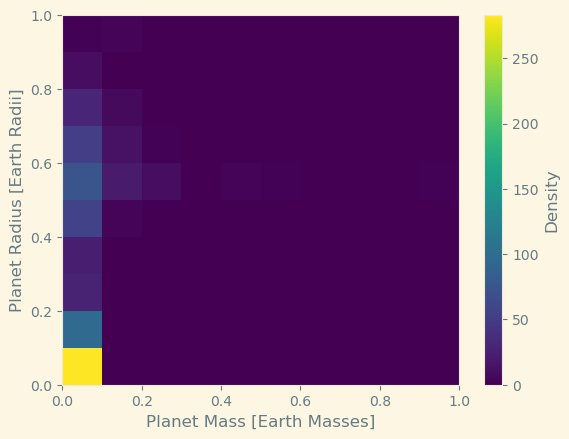

In [8]:
# Min-Max Scaling
min_val_r = np.min(exo_data['Planet Radius [Earth radii]'])
max_val_r = np.max(exo_data['Planet Radius [Earth radii]'])
min_val_m = np.min(exo_data['Planet Mass [Earth masses]'])
max_val_m = np.max(exo_data['Planet Mass [Earth masses]'])
normalized_r = (exo_data['Planet Radius [Earth radii]'] - min_val_r)/(max_val_r - min_val_r)
normalized_m = (exo_data['Planet Mass [Earth masses]'] - min_val_m)/(max_val_m - min_val_m)


fig, ax = plt.subplots()
#hist = ax.hist2d(np.log10(exo_data['Planet Mass [Earth masses]']), np.log10(exo_data['Planet Radius [Earth radii]']), cmin=1, bins=50, cmap='viridis')
hist = ax.hist2d((normalized_m), (normalized_r))
#ax.colorbar() #label this - also normalize to make it so it's probability of finding a planet with this radius and mass
#can also add x's to add to this plot to show "how" I'm pulling data from here for the hab zone distribution
#use a custom image as a scatterplot rep using earth to mark, use biggest zorder to add to foreground ie zorder=1000
ax.set_xlabel("Planet Mass [Earth Masses]")
ax.set_ylabel("Planet Radius [Earth Radii]")
cbar = plt.colorbar(hist[3], ax=ax)
cbar.set_label('Density')
#path_earf = Image.open('/Users/shirin/Desktop/comp_meth/earf.png')
#plt.scatter(1,1, label='Earth', marker=path_earf)

We now want to use a MC method to sample from the population database, and we want to make it generalizable so that I can call on an argument and just use it. I should create a function that takes all arguments that are headers in the file, and then runs the MC method on them.

In [9]:
N = 200
def mc_sampling(exo_data, x, y, xaxis, yaxis):
    exo_list = len(exo_data)
    choose_exos = []
     
    directory = str(N)+'_planets/'
    directory = rename(directory)
    os.makedirs(directory, exist_ok=True)
    parent_dir = "/Users/shirin/Desktop/comp_meth/final_project/"
    image_folder=os.path.join(parent_dir, directory)

    for i in range(N):
        random_select = np.random.randint(0, exo_list-1)
        choose_exos.append(exo_data.iloc[random_select])

        #Plotting each point 
        plt.figure(figsize=(6,6))
        plt.title('Monte Carlo Sampling')
        plt.xlabel(str(x))
        plt.ylabel(str(y))
        plt.xlim(0, xaxis)
        plt.ylim(0, yaxis)
        plt.scatter(choose_exos[-1][x], choose_exos[-1][y], color='red', marker='o', alpha=0.5)  # Newly added point in red
        
        for j in range(i+1):
            plt.scatter(choose_exos[j][x], choose_exos[j][y], marker='o', alpha=0.5)
            
        plt.savefig(directory+str(i)+'.png')
        plt.close()

    plt.show(block=False)    
    return pd.DataFrame(choose_exos)

random_exos = mc_sampling(exo_data, x='Planet Mass [Earth masses]', y='Planet Radius [Earth radii]', xaxis=2000, yaxis=30)
mceed_exos = pd.DataFrame(random_exos)
#print(random_exos)

Let's make a video!

In [ ]:
directory = str(N)+'_planets/'
directory = rename(directory)
os.makedirs(directory, exist_ok=True)
parent_dir = "/Users/shirin/Desktop/comp_meth/final_project/"
image_folder=os.path.join(parent_dir, directory)
# Collect image files from the folder
image_files = sorted([os.path.join(image_folder, img)
                    for img in os.listdir(image_folder)
                    if img.endswith(".png")], key=lambda x: int(''.join(filter(str.isdigit, x))))

#Let's save our video!
fps = 15
clip = ImageSequenceClip(image_files, fps=fps)
output_video = str(N)+'_planets_output.mp4'
clip.write_videofile(output_video, codec='libx264', fps=fps)
Video(output_video)


Moviepy - Building video 200_planets_output.mp4.
Moviepy - Writing video 200_planets_output.mp4



Moviepy - Done !
Moviepy - video ready 200_planets_output.mp4


The above random selection and movie-making code are to show how planets are selected at random. Since we know we have a total of 731 planets, and we sampled 200 of them, we are looking at 200/731 planets, or about 27% of the planets!

<Axes: xlabel='Planet Mass [Earth masses]', ylabel='Planet Radius [Earth radii]'>

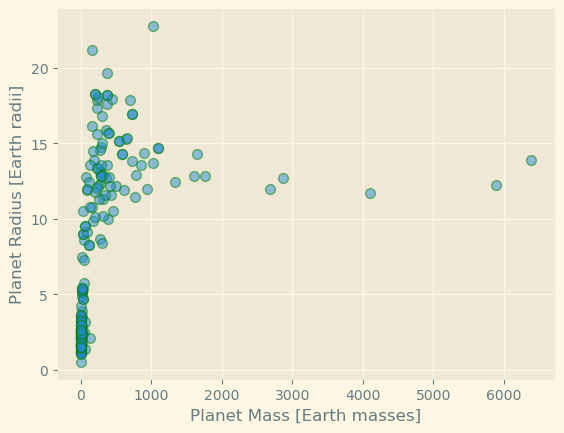

In [ ]:
mceed_exos.plot(x='Planet Mass [Earth masses]', y='Planet Radius [Earth radii]', kind='scatter', alpha=0.5, s=50, edgecolor='green')

Now, to take a look at our distribution, we should add our boundaries. A helpful way to figure out what boundaries will be helpful in figuring out which planets can be hypothetically considered habitable candidates, we can narrow down the masses and radii. I'll be using ranges considered by the Planetary Habitability Laboratory @ UPR Arecibo (phl.upra.edu), that is a wonderful resource in general. As mentioned at the beginning, I personally think that a planet's mass and radius are easier to think about as we're thinking about the potential habitability of the planet itself, so we'll start with those bounds and then have further discussions about the host star/condition of the system. We're going to zoom in much deeper on the plot, where you may have noticed there's a high density of planets. Since we're going to just start with these two parameters, I think we can consider ourselves absurdly hopefully optimists and we'll take a look at data from the PHL @ UPR Arecibo's optimistic range combined with their conservative range. Our values will go from 0.5<Radius<2.5 and 0.1<Mass<10.

In [ ]:
#random_exos.where(columns=[]'Planet Mass [Earth masses]'<=10)
bounding_mask = (mceed_exos['Planet Mass [Earth masses]'] >= 0.1) & (mceed_exos['Planet Mass [Earth masses]'] <= 10) & (mceed_exos['Planet Radius [Earth radii]'] >= 0.5) & (mceed_exos['Planet Radius [Earth radii]'] <= 2.5)
mceed_exos = mceed_exos[bounding_mask]

200


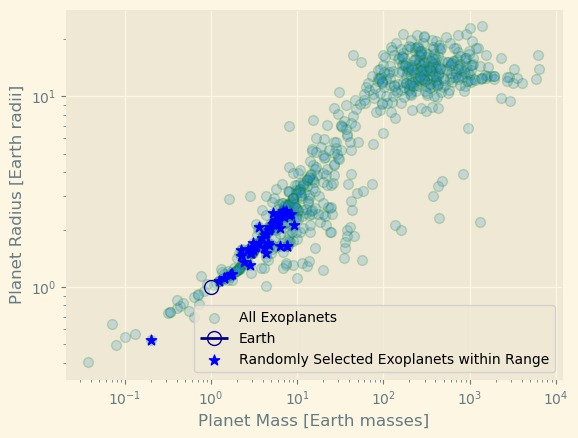

In [ ]:
ax = exo_data.plot(x='Planet Mass [Earth masses]', y='Planet Radius [Earth radii]', kind='scatter', alpha=0.2, s=50, edgecolor='green', label='All Exoplanets')
print(len(random_exos))
ax.plot(1, 1, marker='o', color='white', alpha=0.2, markersize=10)
ax.plot(1, 1, marker='o', color='darkblue', markersize=10, markerfacecolor='none', label='Earth', zorder=1000)
mceed_exos.plot(x='Planet Mass [Earth masses]', y='Planet Radius [Earth radii]', kind='scatter', logx=True, logy=True, s=60, ax=ax, color='blue', marker='*', alpha=1, label='Randomly Selected Exoplanets within Range')
plt.legend()

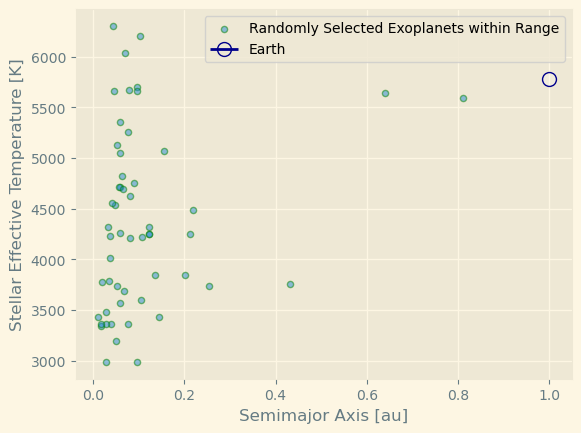

In [ ]:
ax = mceed_exos.plot(x='Semimajor Axis [au]', y='Stellar Effective Temperature [K]', kind='scatter', alpha=0.5, edgecolor='green', label='Randomly Selected Exoplanets within Range')
ax.plot(1, 5780, marker='o', color='white', alpha=0.2, markersize=10)
ax.plot(1, 5780, marker='o', color='darkblue', markersize=10, markerfacecolor='none', label='Earth', zorder=1000)
plt.legend()

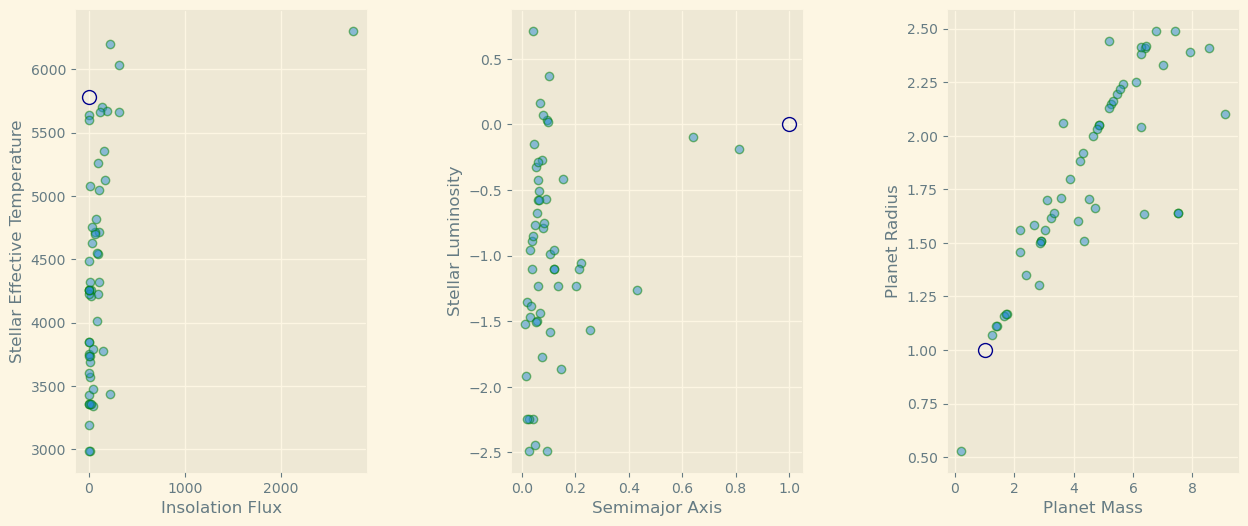

In [ ]:
fig = plt.figure(figsize=(15, 6))

ax1 = fig.add_subplot(131)
ax1.scatter(mceed_exos['Insolation Flux [Earth flux]'], mceed_exos['Stellar Effective Temperature [K]'], alpha=0.5, edgecolor='green')
ax1.plot(1, 5780, marker='o', color='white', alpha=0.2, markersize=10)
ax1.plot(1, 5780, marker='o', color='darkblue', markersize=10, markerfacecolor='none', label='Earth', zorder=1000)
ax1.set_xlabel('Insolation Flux')
ax1.set_ylabel('Stellar Effective Temperature')

ax2 = fig.add_subplot(132)
ax2.scatter(mceed_exos['Semimajor Axis [au]'], mceed_exos['Stellar Luminosity [log10(solar)]'], alpha=0.5, edgecolor='green')
ax2.plot(1, 0, marker='o', color='white', alpha=0.2, markersize=10)
ax2.plot(1, 0, marker='o', color='darkblue', markersize=10, markerfacecolor='none', label='Earth', zorder=1000)
ax2.set_xlabel('Semimajor Axis')
ax2.set_ylabel('Stellar Luminosity')

ax3 = fig.add_subplot(133)
ax3.scatter(mceed_exos['Planet Mass [Earth masses]'], mceed_exos['Planet Radius [Earth radii]'], alpha=0.5, edgecolor='green')
ax3.plot(1, 1, marker='o', color='white', alpha=0.2, markersize=10)
ax3.plot(1, 1, marker='o', color='darkblue', markersize=10, markerfacecolor='none', label='Earth', zorder=1000)
ax3.set_xlabel('Planet Mass')
ax3.set_ylabel('Planet Radius')

plt.subplots_adjust(wspace=0.5)
plt.show()

In [ ]:
N = 15
def mc_sampling(data, x, y, xaxis, yaxis):
    exo_list = len(data)
    choose_exos = []
     
    directory = 'twice_'+str(N)+'_planets/'
    directory = rename(directory)
    os.makedirs(directory, exist_ok=True)
    parent_dir = "/Users/shirin/Desktop/comp_meth/final_project/"
    image_folder=os.path.join(parent_dir, directory)

    for i in range(N):
        random_select = np.random.randint(0, exo_list-1)
        choose_exos.append(mceed_exos.iloc[random_select])

        #Plotting each point 
        plt.figure(figsize=(6,6))
        plt.title('Monte Carlo Sampling')
        plt.xlabel(str(x))
        plt.ylabel(str(y))
        plt.xlim(0, xaxis)
        plt.ylim(0, yaxis)
        plt.scatter(choose_exos[-1][x], choose_exos[-1][y], xlim=(0,10), ylim=(0,2.5), color='red', marker='o', alpha=0.5)
        
        for j in range(i+1):
            plt.scatter(choose_exos[j][x], choose_exos[j][y], xlim=(0,10), ylim=(0,2.5), marker='o', alpha=0.5)
            
        plt.savefig(directory+str(i)+'.png')
        plt.close()

    plt.show(block=False)    
    return pd.DataFrame(choose_exos)

mceed_exos2 = mc_sampling(mceed_exos, x='Planet Mass [Earth masses]', y='Planet Radius [Earth radii]', xaxis=2000, yaxis=30)

In [ ]:
directory = 'twice_'+str(N)+'_planets/'
directory = rename(directory)
os.makedirs(directory, exist_ok=True)
parent_dir = "/Users/shirin/Desktop/comp_meth/final_project/"
image_folder=os.path.join(parent_dir, directory)
# Collect image files from the folder
image_files = sorted([os.path.join(image_folder, img)
                    for img in os.listdir(image_folder)
                    if img.endswith(".png")], key=lambda x: int(''.join(filter(str.isdigit, x))))

#Let's save our video!
fps = 1
clip = ImageSequenceClip(image_files, fps=fps)
output_video = 'twice_'+str(N)+'_planets_output.mp4'
clip.write_videofile(output_video, codec='libx264', fps=fps)
Video(output_video)

Moviepy - Building video twice_15_planets_output.mp4.
Moviepy - Writing video twice_15_planets_output.mp4



Moviepy - Done !
Moviepy - video ready twice_15_planets_output.mp4


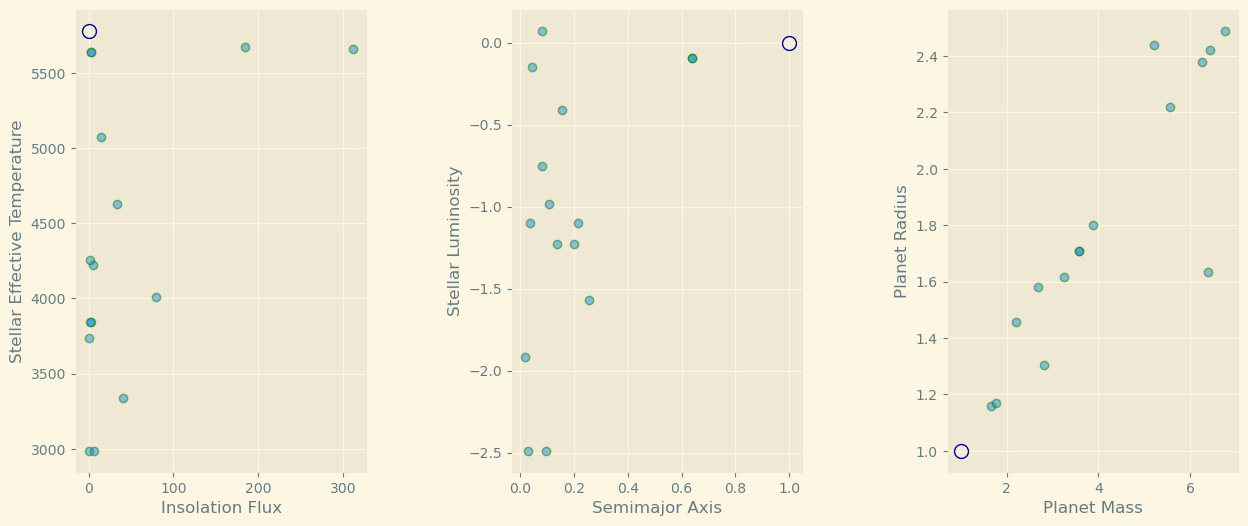

In [ ]:
fig = plt.figure(figsize=(15, 6))

ax1 = fig.add_subplot(131)
ax1.scatter(mceed_exos2['Insolation Flux [Earth flux]'], mceed_exos2['Stellar Effective Temperature [K]'], alpha=0.5, edgecolor='green')
ax1.plot(1, 5780, marker='o', color='white', alpha=0.2, markersize=10)
ax1.plot(1, 5780, marker='o', color='darkblue', markersize=10, markerfacecolor='none', label='Earth', zorder=1000)
ax1.set_xlabel('Insolation Flux')
ax1.set_ylabel('Stellar Effective Temperature')

ax2 = fig.add_subplot(132)
ax2.scatter(mceed_exos2['Semimajor Axis [au]'], mceed_exos2['Stellar Luminosity [log10(solar)]'], alpha=0.5, edgecolor='green')
ax2.plot(1, 0, marker='o', color='white', alpha=0.2, markersize=10)
ax2.plot(1, 0, marker='o', color='darkblue', markersize=10, markerfacecolor='none', label='Earth', zorder=1000)
ax2.set_xlabel('Semimajor Axis')
ax2.set_ylabel('Stellar Luminosity')

ax3 = fig.add_subplot(133)
ax3.scatter(mceed_exos2['Planet Mass [Earth masses]'], mceed_exos2['Planet Radius [Earth radii]'], alpha=0.5, edgecolor='green')
ax3.plot(1, 1, marker='o', color='white', alpha=0.2, markersize=10)
ax3.plot(1, 1, marker='o', color='darkblue', markersize=10, markerfacecolor='none', label='Earth', zorder=1000)
ax3.set_xlabel('Planet Mass')
ax3.set_ylabel('Planet Radius')

plt.subplots_adjust(wspace=0.5)
plt.show()

As we can see above, marking down where Earth is can be quite helpful. In terms of just mass and radius, since we selected what we wanted to see using a mask, we cn comfortably say that we've selected 